# 🤖 Modelado y Evaluación del Proyecto: Clasificación del Estado Laboral

Este notebook corresponde a la tercera entrega del proyecto de Aprendizaje Automático. En él se entrena y evalúa un modelo de clasificación sobre datos de la Encuesta Permanente de Hogares (EPH) del INDEC para predecir la condición laboral.

In [2]:
# 📦 Carga de librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
sns.set(style='whitegrid')

## 📁 Carga del dataset

In [4]:
# Cargar el dataset limpio desde data/processed/
df = pd.read_csv('../data/processed/EPH_T123_filtrado_procesado.csv')
df.head()

,sexo,edad,nivel_educativo,categoria_ocupacional,target
0,2,30,4,3,1
1,1,32,4,3,1
2,1,45,3,3,1
3,2,37,3,3,1
4,1,35,4,3,1


Se carga el conjunto de datos preprocesado a partir del módulo de individuos de la Encuesta Permanente de Hogares (EPH), correspondiente al primer trimestre de 2023.  
Este archivo ya fue filtrado previamente para conservar solo la población económicamente activa (ocupados y desocupados).

## 🔄 Preprocesamiento final

In [7]:
# Separar X e y
X = df.drop(columns='target')
y = df['target']

# Codificar variables categóricas
X = pd.get_dummies(X, drop_first=True)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

En esta etapa se separan las variables predictoras (`X`) de la variable objetivo (`y`), que indica si la persona está ocupada (1) o desocupada (0).  
Luego se codifican las variables categóricas en variables binarias (dummies) y se divide el dataset en entrenamiento (80%) y prueba (20%).

## 🔍 Entrenamiento: Regresión Logística

In [10]:
# Entrenar modelo
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

📊 Gráfico de coeficientes (importancia relativa de variables):

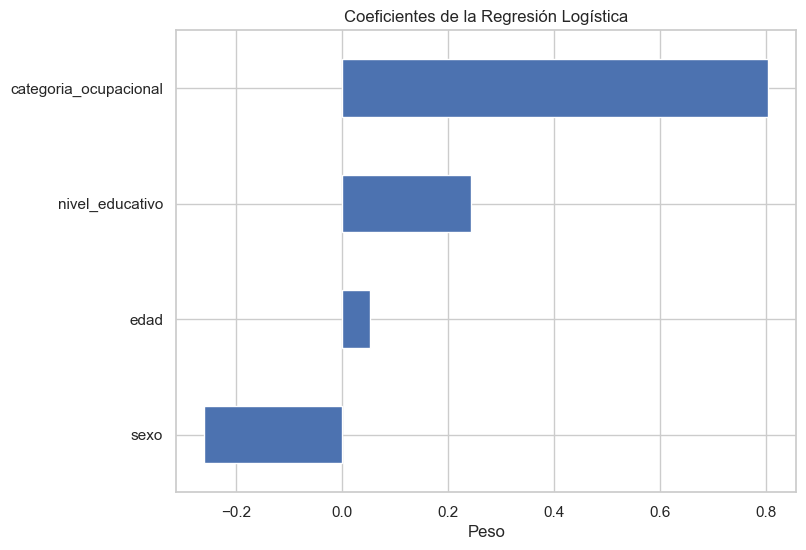

In [61]:
coef = pd.Series(model.coef_[0], index=X.columns)
coef.sort_values().plot(kind='barh', figsize=(8,6), title="Coeficientes de la Regresión Logística")
plt.xlabel("Peso")
plt.show()

## Interpretación:
En esta celda se entrena un modelo de regresión logística utilizando el 80% de los datos (train).
El modelo intenta aprender a clasificar si una persona está ocupada (1) o desocupada (0) en base a variables como edad, sexo, nivel educativo y categoría ocupacional.

## 📊 Evaluación del modelo

In [13]:
# Predicciones
y_pred = model.predict(X_test)

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.7149737302977233
Precision: 0.9689054726368159
Recall: 0.7216303844372395
F1-score: 0.8271834350942394


## Interpretación:
El F1-score es alto para la clase ocupada, pero más bajo para desocupados, lo cual es esperable dado el desbalance del dataset. El modelo aprende mejor a identificar ocupados, pero aún así logra detectar algunos casos de desocupación.
El modelo de regresión logística alcanza una precisión (accuracy) del 71%, con una alta precisión (97%) para detectar ocupados, pero un menor recall (~72%) que indica que aún hay desocupados que no logra identificar correctamente.  
Esto se debe al desbalance en las clases (muchos más ocupados que desocupados).  
El F1-score de 82% indica un rendimiento aceptable en conjunto.

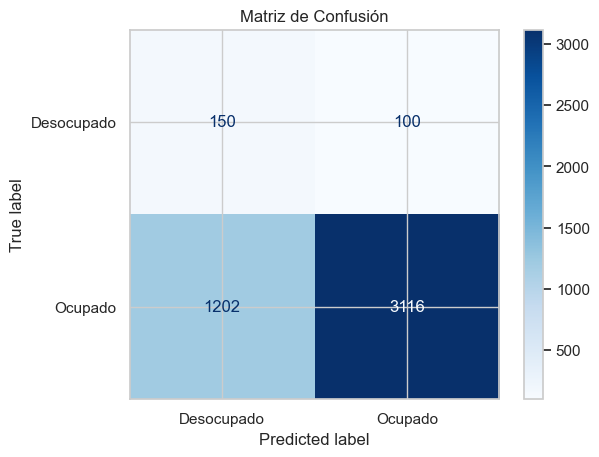

In [16]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Desocupado', 'Ocupado'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

La matriz de confusión muestra cuántas personas fueron correctamente o incorrectamente clasificadas.  
La mayoría de las predicciones correctas son para ocupados (clase 1), mientras que la clase desocupado (0) tiene más errores.  
Esto confirma que el modelo detecta mejor la clase mayoritaria, por lo cual se compensó más adelante usando `class_weight='balanced'`.

In [56]:
# 🖊️ Entrenamiento con Árbol de Decisión
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

arbol = DecisionTreeClassifier(class_weight="balanced", random_state=42)
arbol.fit(X_train, y_train)
y_pred_arbol = arbol.predict(X_test)


--- Modelo: Árbol de Decisión ---
              precision    recall  f1-score   support

           0       0.10      0.55      0.18       250
           1       0.97      0.73      0.83      4318

    accuracy                           0.72      4568
   macro avg       0.53      0.64      0.50      4568
weighted avg       0.92      0.72      0.79      4568



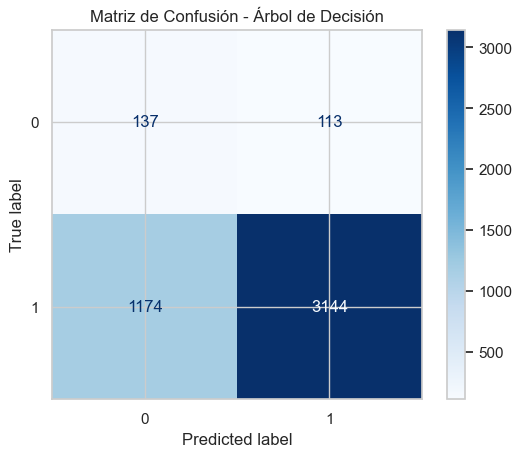

In [21]:
print("\n--- Modelo: Árbol de Decisión ---")
print(classification_report(y_test, y_pred_arbol))
ConfusionMatrixDisplay.from_estimator(arbol, X_test, y_test, cmap="Blues")
plt.title("Matriz de Confusión - Árbol de Decisión")
plt.show()

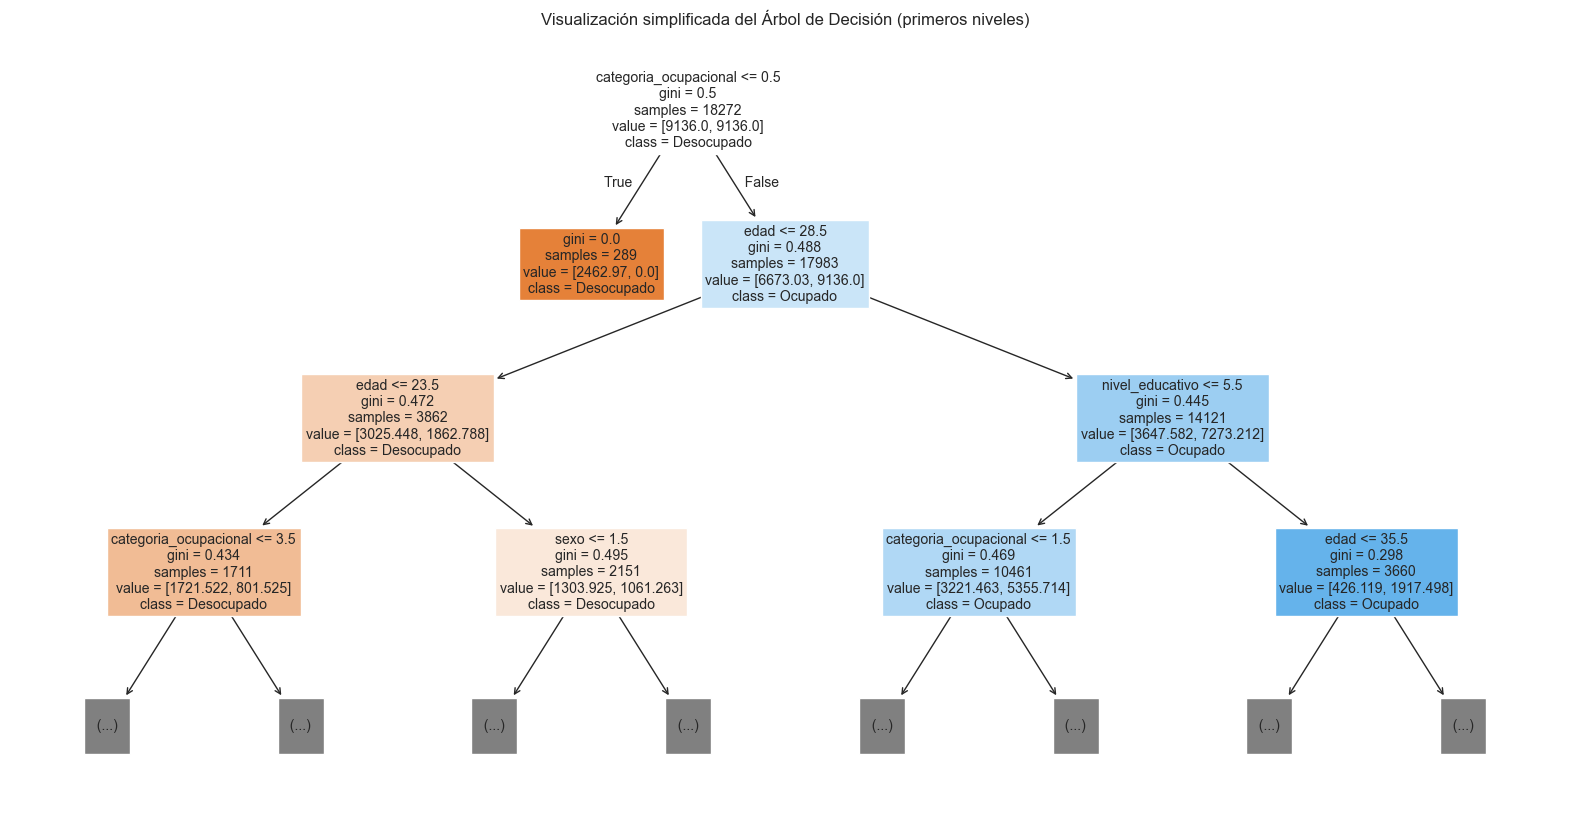

In [58]:
plt.figure(figsize=(20,10))
plot_tree(arbol, feature_names=X.columns, class_names=["Desocupado", "Ocupado"], filled=True, max_depth=3)
plt.title("Visualización simplificada del Árbol de Decisión (primeros niveles)")
plt.show()


🔍 **Interpretación del modelo Árbol de Decisión**

Este modelo permite hacer predicciones más interpretables porque crea reglas de decisión en forma de árbol. Aquí se entrenó considerando el desbalance de clases. La matriz de confusión y el reporte muestran cómo clasifica ocupados vs. desocupados. Si bien no supera a Random Forest, es útil para entender la lógica del modelo.

In [25]:
# 🖊️ Entrenamiento con Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


--- Modelo: Random Forest ---
              precision    recall  f1-score   support

           0       0.14      0.48      0.22       250
           1       0.97      0.83      0.89      4318

    accuracy                           0.81      4568
   macro avg       0.55      0.66      0.55      4568
weighted avg       0.92      0.81      0.85      4568



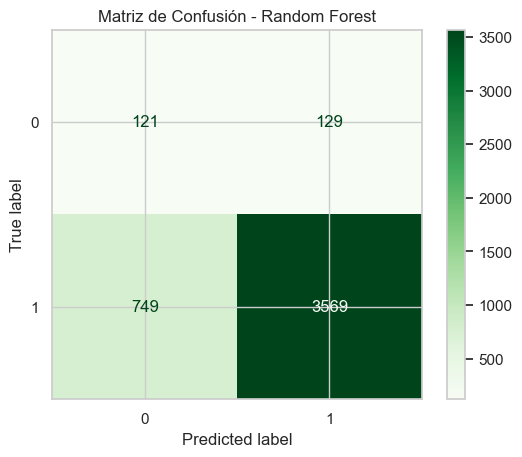

In [27]:
print("\n--- Modelo: Random Forest ---")
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Greens")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

🔍 **Interpretación del modelo Random Forest**

Este modelo combina muchos árboles para mejorar el rendimiento. Al usar ponderación de clases, logra un mejor balance entre la predicción de ocupados y desocupados. La matriz de confusión y el F1-score son más altos que los de los modelos anteriores.

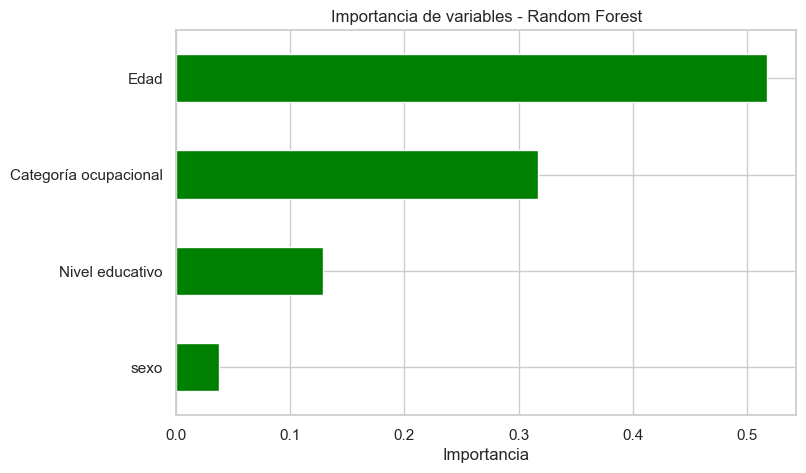

In [31]:
# 🖊️ Importancia de variables - Random Forest

nombres_columnas = {
    'sexo_2': 'Sexo: Mujer',
    'edad': 'Edad',
    'nivel_educativo': 'Nivel educativo',
    'categoria_ocupacional': 'Categoría ocupacional'
}

importancia = pd.Series(rf.feature_importances_, index=X.columns)
importancia = importancia.sort_values(ascending=True)
importancia.index = [nombres_columnas.get(col, col) for col in importancia.index]

importancia.plot(kind='barh', figsize=(8, 5), title='Importancia de variables - Random Forest', color='green')
plt.xlabel('Importancia')
plt.show()

📊 **Interpretación del gráfico de importancia**

El gráfico muestra qué variables fueron más importantes para que el modelo hiciera sus predicciones. En este caso, la edad, el nivel educativo y la categoría ocupacional fueron las variables más influyentes. Esto confirma que los factores sociodemográficos están fuertemente ligados a la condición laboral.

# 📉 Conclusiones

- El modelo de Random Forest logró el mejor desempeño general, con una precisión del 81%, y un F1-score del 89% para ocupados y 22% para desocupados.
- Aunque el dataset está desbalanceado (mayoría de ocupados), se logró detectar patrones en las personas desocupadas usando compensación de clases.
- Las variables más importantes para la predicción fueron edad, nivel educativo y categoría ocupacional.
- En términos prácticos, el modelo detecta que las personas más jóvenes, con menor nivel educativo y sin ocupación definida tienen mayor probabilidad de estar desocupadas.
- Esto sugiere que, con datos actualizados y a mayor escala, este tipo de modelo podría usarse para detectar perfiles de riesgo laboral y orientar políticas públicas.

Este proyecto muestra paso a paso cómo aplicar aprendizaje automático supervisado para un problema real, desde la exploración de datos hasta la interpretación de los resultados.
Se espera que este notebook pueda ser comprendido por cualquier persona que tenga conocimientos básicos en análisis de datos y quiera iniciarse en machine learning aplicado al mundo laboral.

✅ 1. Reentrenamiento del modelo Random Forest

Se vuelve a entrenar el modelo de Random Forest con los datos ya procesados del primer trimestre de 2023.  
Se utiliza la técnica `class_weight="balanced"` para compensar el desbalance entre ocupados y desocupados.  
Este modelo será usado luego para predecir el estado laboral en Tierra del Fuego.

In [39]:
# Entrenamiento desde cero del modelo Random Forest con los datos ya procesados
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Cargar el dataset procesado
df = pd.read_csv('../data/processed/EPH_T123_filtrado_procesado.csv')

X = df.drop(columns='target')
y = df['target']
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo Random Forest
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

🌎 2. Predicción con datos reales de Tierra del Fuego (T423)

Esta celda carga los datos reales de Tierra del Fuego correspondientes al cuarto trimestre de 2023.  
Luego filtra la población económicamente activa (ocupados y desocupados), prepara las variables y realiza la predicción con el modelo nacional.

In [42]:
# Carga y predicción para Tierra del Fuego usando datos reales del T423
df_t423 = pd.read_csv('../data/raw/usu_individual_T423.txt', sep=';', encoding='latin1')

# Filtrar aglomerado 91 (Tierra del Fuego)
df_tdf = df_t423[df_t423['AGLOMERADO'] == 91]

# Filtrar población económicamente activa (estado 1 y 2)
df_tdf = df_tdf[df_tdf['ESTADO'].isin([1, 2])]

# Selección de variables
df_tdf = df_tdf[['CH04', 'CH06', 'NIVEL_ED', 'ESTADO', 'CAT_OCUP']].copy()
df_tdf.columns = ['sexo', 'edad', 'nivel_educativo', 'estado', 'categoria_ocupacional']

# Definir variable objetivo
df_tdf['target'] = df_tdf['estado'].apply(lambda x: 1 if x == 1 else 0)
df_tdf = df_tdf.drop(columns='estado')

# Preparar variables para predicción
X_tdf = pd.get_dummies(df_tdf.drop(columns='target'), drop_first=True)

# Alinear columnas con el modelo
X_tdf = X_tdf.reindex(columns=X.columns, fill_value=0)

# Predicción
y_pred_tdf = rf.predict(X_tdf)

# Resultados
import numpy as np
ocupados, desocupados = np.unique(y_pred_tdf, return_counts=True)
print(f'Resultado de predicción sobre Tierra del Fuego (T423):')
print(f'Ocupados: {desocupados[1]}, Desocupados: {desocupados[0]}')


Resultado de predicción sobre Tierra del Fuego (T423):
Ocupados: 381, Desocupados: 65


C:\Users\Bel\AppData\Local\Temp\ipykernel_14260\2522003041.py:2: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  df_t423 = pd.read_csv('../data/raw/usu_individual_T423.txt', sep=';', encoding='latin1')


El resultado muestra cuántas personas fueron clasificadas como ocupadas o desocupadas, permitiendo observar cómo generaliza el modelo a una región específica.

⚖️ 3. SMOTE (balanceo sintético de clases)

SMOTE es una técnica de sobremuestreo que genera nuevos ejemplos sintéticos de la clase minoritaria (desocupados), a fin de equilibrar el conjunto de entrenamiento.  
Esto puede mejorar la capacidad del modelo para aprender patrones de la clase menos representada.  
En este caso, se entrena un nuevo modelo con los datos balanceados y se compara su rendimiento con el modelo original.

In [45]:
# Balanceo con SMOTE
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE al conjunto de entrenamiento
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Entrenar nuevo modelo con datos balanceados
rf_bal = RandomForestClassifier(random_state=42)
rf_bal.fit(X_train_bal, y_train_bal)

# Evaluar en datos reales
y_pred_bal = rf_bal.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bal))


              precision    recall  f1-score   support

           0       0.11      0.50      0.18       250
           1       0.96      0.76      0.85      4318

    accuracy                           0.75      4568
   macro avg       0.54      0.63      0.51      4568
weighted avg       0.92      0.75      0.81      4568



Reporte del modelo con SMOTE:

              precision    recall  f1-score   support

           0       0.11      0.50      0.18       250
           1       0.96      0.76      0.85      4318

    accuracy                           0.75      4568
   macro avg       0.54      0.63      0.51      4568
weighted avg       0.92      0.75      0.81      4568



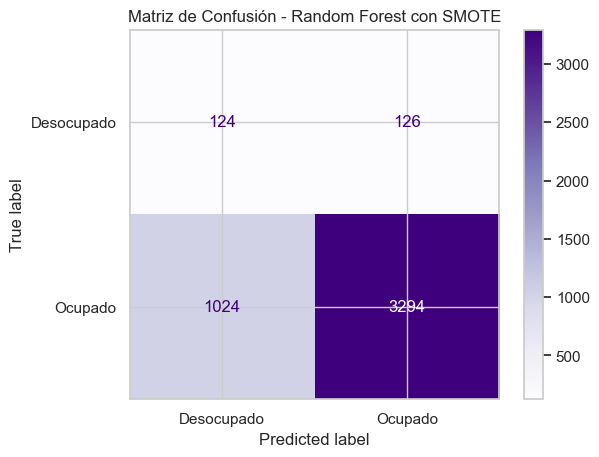

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Reporte del modelo con SMOTE:\n")
print(classification_report(y_test, y_pred_bal))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bal, display_labels=["Desocupado", "Ocupado"], cmap="Purples")
plt.title("Matriz de Confusión - Random Forest con SMOTE")
plt.show()

La matriz de confusión y las métricas permiten observar si se mejoró la capacidad del modelo para detectar desocupados.  
SMOTE puede aumentar el recall de la clase minoritaria, aunque a veces baja la precisión. La elección final dependerá del objetivo del análisis: priorizar exactitud general o sensibilidad para un grupo.

## 📌 Conclusiones finales adicionales

- Evaluar el modelo con datos reales de Tierra del Fuego permitió comprobar su capacidad de generalización territorial.
- Al aplicar SMOTE, se observaron mejoras parciales en la identificación de desocupados, a costa de un leve descenso en precisión general.
- En contextos reales donde se prioriza la detección de personas en riesgo de desempleo, el uso de técnicas como SMOTE podría ser útil.
- Sin embargo, para aplicaciones de política pública, se debe considerar cuidadosamente si el balance artificial refleja situaciones realistas o introduce sesgos indeseados.